<a href="https://colab.research.google.com/github/jjangmo91/ParkLab/blob/main/project/2025%20NASA%20Space%20Apps%20Challenge/01_mekong_flood_analysis_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap

# Earth Engine 인증
ee.Authenticate()
# Earth Engine 초기화
ee.Initialize(project='ee-jjangmo91') # 본인 계정

In [18]:
# Phase 1: 기준선 설정(Landsat & JRC)
# 목표: 댐 영향이 본격화 되기 이전 메콩강 하류 모습 정의
# step1: Landsat 5 이미지를 이용해 건기와 우기의 자연색(Natural Color) 이미지 생성
# step2: JRC Global Surface Water 데이터셋의 seasonality 밴드를 활용, 1년 중 항상 물이 있었던 곳(Permanent)과 계절에 따라 물이 차는 곳(Seasonal) 시각화
# 결과: 댐 영향 이전의 시각적 / 질적 기준선 설정

In [ ]:
# 분석 파라미터 설정
# Area of Interset, AOI: 캄보디아 프놈펜, 톤레삽 호수, 베트남 메콩 델타 포함
aoi = ee.Geometry.Rectangle([103.0, 9.5, 107.0, 13.5])

# 기준선 분석 기간 (댐 영향 이전 / 1년치 건기 우기 확)
pre_dam_start_year = 2005
pre_dam_end_year = 2006

In [14]:
# Landsat Collection 2 스케일링 및 구름 마스킹 함수 정의
def scale_and_mask_l5c2(image):
    # QA_PIXEL 밴드에서 구름(비트3)과 구름 그림자(비트4) 정보 추출
    cloud_shadow_bit_mask = 1 << 4
    clouds_bit_mask = 1 << 3
    qa_pixel = image.select('QA_PIXEL')
    # 구름과 그림자가 없는 깨끗한 픽셀만 선택
    mask = qa_pixel.bitwiseAnd(cloud_shadow_bit_mask).eq(0) \
                   .And(qa_pixel.bitwiseAnd(clouds_bit_mask).eq(0))

    # 광학 밴드(SR_B*)에 스케일 팩터와 오프셋 적용
    # 열 밴드(ST_B6)는 다른 스케일을 가지므로 따로 처리
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B6').multiply(0.00341802).add(149.0)

    # 스케일링된 밴드와 마스크를 원본 이미지에 다시 추가하고 적용
    return image.addBands(optical_bands, None, True) \
                .addBands(thermal_bands, None, True) \
                .updateMask(mask)

# 건기(Dry Season) 데이터 처리
dry_season_start = f'{pre_dam_start_year}-11-01'
dry_season_end = f'{pre_dam_end_year}-04-30'

landsat_dry = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filterBounds(aoi) \
    .filterDate(dry_season_start, dry_season_end) \
    .map(scale_and_mask_l5c2) \
    .median() \
    .clip(aoi)

# 우기(Wet Season) 데이터 처리
wet_season_start = f'{pre_dam_end_year}-05-01'
wet_season_end = f'{pre_dam_end_year}-10-31'

landsat_wet = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filterBounds(aoi) \
    .filterDate(wet_season_start, wet_season_end) \
    .map(scale_and_mask_l5c2) \
    .median() \
    .clip(aoi)

# 시각화 파라미터 (Collection 2에 맞게 밴드 이름과 값 범위 수정)
vis_params_landsat = {
    'bands': ['SR_B3', 'SR_B2', 'SR_B1'], # 자연색 조합 (Red, Green, Blue)
    'min': 0.0,
    'max': 0.3 # 표면 반사율(Surface Reflectance) 값 범위
}

In [15]:
# JRC Global Surface Water 데이터셋 v1.4 불러오기
jrc_data = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').clip(aoi)

# 'seasonality' 밴드는 물의 계절성을 분류함
seasonality = jrc_data.select('seasonality')

# 시각화를 위한 파라미터 설정
vis_params_jrc = {
    'min': 1,
    'max': 4,
    'palette': ['#0000FF', '#2395a7', '#52e338', '#9be338'] # 파랑(영구), 하늘~초록(계절)
}

In [17]:
# 대화형 지도 생성
m = geemap.Map(center=[11.5, 105.5], zoom=8)

# 지도에 레이어 추가
m.addLayer(landsat_dry, vis_params_landsat, 'Landsat C2 - 건기 (2005-2006)')
m.addLayer(landsat_wet, vis_params_landsat, 'Landsat C2 - 우기 (2006)')
m.addLayer(seasonality, vis_params_jrc, 'JRC 물 계절성 v1.4 (Baseline)')

# 레이어 컨트롤 추가
m.addLayerControl()

# 지도 표시
m

Map(center=[11.5, 105.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [19]:
# Phase 2: SAR 기반 홍수 면적 정령화(Sentinel-1)
# 목표: 댐 영향 이후(2015-2024)의 기간 동안, 매년 우기의 최대 홍수 범람 면적을 객관적인 수치로 계산
# step1: 매년 우기(8-9월)의 Sentinel-1 SAR 이미지를 모두 수집
# step2: 여러 이미지 중 가장 어둡게 나타나는 픽셀 값을 선택하여 구름이나 노이즈 영향을 최소화하고, 물일 가능성 높은 지역 추출
# step3: -16dB 임계값(Threshold) 기준, 물 지역 분류하고 해당 지역 총면적 계산
# 결과: 연도별 홍수 면적 변화 데이터 생성, 그래프 시각화

In [20]:
# 분석할 연도 범위 설정
post_dam_start_year = 2015
post_dam_end_year = 2024

# 물을 탐지하기 위한 SAR 후방산란계수(backscatter) 임계값(dB)
# 일반적으로 VV 편파에서 -16dB 이하면 물일 가능성이 높음
water_threshold = -16

In [21]:
import pandas as pd

# 연도별 홍수 면적을 저장할 리스트
flood_areas = []

print(f"연도별 홍수 면적 계산을 시작합니다... ({post_dam_start_year} - {post_dam_end_year})")

for year in range(post_dam_start_year, post_dam_end_year + 1):
    # 해당 연도의 우기(8월 1일 ~ 9월 30일)로 기간 설정
    start_date = f'{year}-08-01'
    end_date = f'{year}-09-30'

    # Sentinel-1 데이터 컬렉션 불러오기 및 필터링
    s1_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(aoi) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .select('VV')

    # SAR 이미지의 노이즈(speckle)를 줄이기 위해 부드럽게 만드는 필터 적용
    # `.min()`을 사용하여 여러 이미지 중 가장 어두운 픽셀(물일 가능성이 가장 높음)을 선택
    s1_wet_season_min = s1_collection.min().clip(aoi)

    # 임계값보다 낮은 픽셀을 물(1)로, 아닌 픽셀은 마스크(0) 처리하여 물 지도 생성
    water_map = s1_wet_season_min.lt(water_threshold).selfMask()

    # 물 픽셀의 면적 계산
    # ee.Image.pixelArea()는 각 픽셀의 면적을 제곱미터 단위로 가진 이미지를 생성
    # .reduceRegion을 사용하여 AOI 내의 모든 물 픽셀 면적을 합산
    water_area = water_map.multiply(ee.Image.pixelArea()) \
        .reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=aoi,
            scale=30, # 계산의 정밀도 설정
            maxPixels=1e12 # 계산할 픽셀 수의 한도를 매우 크게 설정
        )

    # .getInfo()는 서버의 계산 결과를 클라이언트(Colab)로 가져오는 함수
    water_area_km2 = ee.Number(water_area.get('VV')).divide(1e6).getInfo()

    # 결과 저장
    flood_areas.append({'year': year, 'area_km2': water_area_km2})
    print(f" - {year}년 최대 홍수 면적: {water_area_km2:,.2f} km²")

print("계산이 완료되었습니다.")

# 결과를 pandas DataFrame으로 변환
df_flood = pd.DataFrame(flood_areas)

연도별 홍수 면적 계산을 시작합니다... (2015 - 2024)
 - 2015년 최대 홍수 면적: 35,696.98 km²
 - 2016년 최대 홍수 면적: 46,986.50 km²
 - 2017년 최대 홍수 면적: 58,904.61 km²
 - 2018년 최대 홍수 면적: 67,145.64 km²
 - 2019년 최대 홍수 면적: 63,710.94 km²
 - 2020년 최대 홍수 면적: 52,636.89 km²
 - 2021년 최대 홍수 면적: 56,925.27 km²
 - 2022년 최대 홍수 면적: 55,518.77 km²
 - 2023년 최대 홍수 면적: 54,573.35 km²
 - 2024년 최대 홍수 면적: 56,138.49 km²
계산이 완료되었습니다.


In [ ]:
# Phase 3: 원인 분석(강수량 데이터 통합)
# 목표: 2단계에서 계산된 홍수 면적의 변화가 단순히 강수량 변화 때문인지, 아니면 다른 요인(댐)의 영향 있는지 분석
# step1: 위성 기반 강수량 데이터 CHIRPS 이용, 매년 우기(8-9월) 총 강수량(mm) 계산
# step2: 연도별 '홍수 면적' 데이터와 '총강수량' 데이터 합치기
# step3: 두 변수를 하나의 그래프로 시각화하여 상관관계 파악
# 결과: 홍수 면적 변화의 원인을 추론할 수 있는 설득력 있는 분석 자료 생성

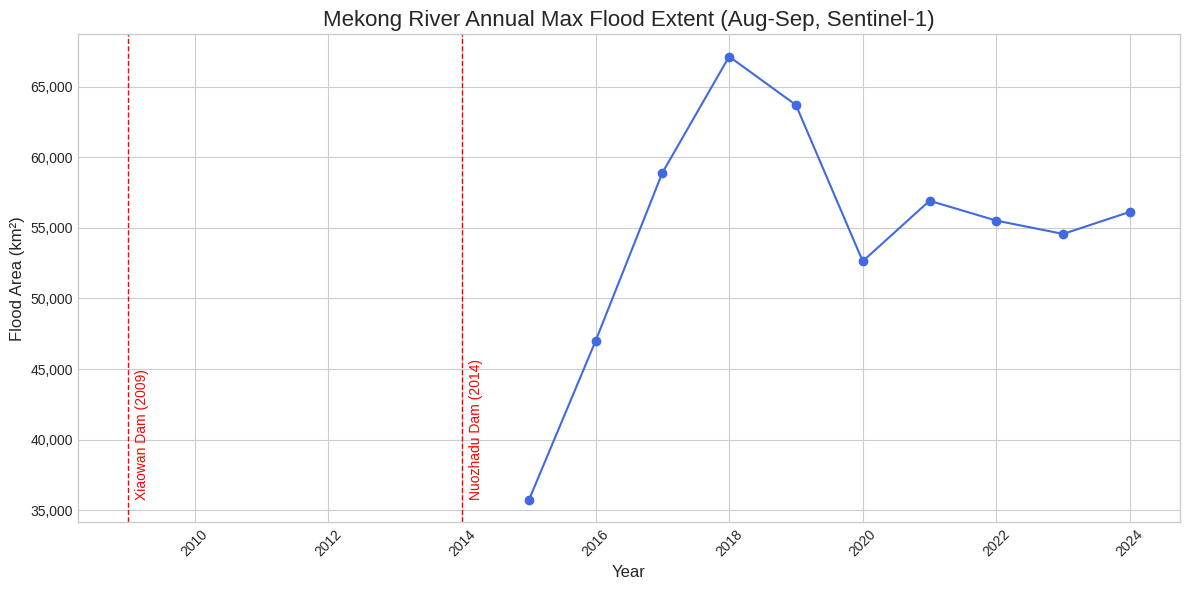

In [22]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_flood['year'], df_flood['area_km2'], marker='o', linestyle='-', color='royalblue')

# 그래프 제목 및 축 레이블 설정
ax.set_title('Mekong River Annual Max Flood Extent (Aug-Sep, Sentinel-1)', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Flood Area (km²)', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ','))) # y축에 콤마 추가

# 중국 주요 댐 완공 시점 표시 (참고용)
ax.axvline(x=2009, color='red', linestyle='--', linewidth=1)
ax.text(2009.1, df_flood['area_km2'].min(), 'Xiaowan Dam (2009)', rotation=90, color='red', verticalalignment='bottom')
ax.axvline(x=2014, color='red', linestyle='--', linewidth=1)
ax.text(2014.1, df_flood['area_km2'].min(), 'Nuozhadu Dam (2014)', rotation=90, color='red', verticalalignment='bottom')


plt.tight_layout()
plt.show()

In [ ]:
# Phase 4: 심층 사례 연구 및 시각화
# 목표: 특정 연도(e.g., 2019년) 선정하여 홍수 발생 과정 상세히 분석, 시각 자료 생성
# step1: 홍수 발생 전과 후 이미지 합성, 새롭게 침수된 지역을 붉은색으로 강조하는 False-color 지도 생성
# 결과: 데이터 분석 결과 직관적 자료 생

In [23]:
# 2019년(예시)의 홍수 지도를 생성
year_to_show = 2019
start_date = f'{year_to_show}-08-01'
end_date = f'{year_to_show}-09-30'
s1_collection = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(aoi).filterDate(start_date, end_date).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).filter(ee.Filter.eq('instrumentMode', 'IW')).select('VV')
s1_wet_season_min = s1_collection.min().clip(aoi)
water_map_2019 = s1_wet_season_min.lt(water_threshold)

# 1단계의 JRC 데이터 다시 불러오기
jrc_data = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').clip(aoi)
jrc_seasonality = jrc_data.select('seasonality')
jrc_permanent_water = jrc_seasonality.eq(1) # 값이 1인 픽셀만 선택 (영구 수역)

# 지도 생성
m2 = geemap.Map(center=[11.5, 105.5], zoom=8)

# 지도에 레이어 추가
# 1. JRC 기준선 (영구 수역)
m2.addLayer(jrc_permanent_water.selfMask(), {'palette': 'darkblue'}, 'Baseline: Permanent Water (JRC)')
# 2. 2019년 Sentinel-1 홍수 탐지 결과
m2.addLayer(water_map_2019.selfMask(), {'palette': 'red'}, f'Sentinel-1 Flood Extent ({year_to_show})')
m2.addLayerControl()
m2

Map(center=[11.5, 105.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [24]:
# 연도별 평균 강수량을 저장할 리스트
precipitation_data = []

# 분석할 연도 범위 (2단계와 동일)
start_year = 2015
end_year = 2024

print(f"연도별 평균 강수량 계산을 시작합니다... ({start_year} - {end_year})")

for year in range(start_year, end_year + 1):
    # 해당 연도의 우기(8월 1일 ~ 9월 30일)로 기간 설정
    start_date = f'{year}-08-01'
    end_date = f'{year}-09-30'

    # CHIRPS Daily 데이터셋 불러오기 및 필터링
    chirps_collection = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
        .filterBounds(aoi) \
        .filterDate(start_date, end_date)

    # 해당 기간의 총강수량 계산 (.sum())
    total_precipitation = chirps_collection.sum().clip(aoi)

    # AOI 내의 평균 총강수량 계산
    mean_precipitation = total_precipitation.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=5000, # CHIRPS 데이터의 해상도에 맞춰 스케일 설정
        maxPixels=1e12
    )

    # 서버에서 계산된 값을 가져옴
    precipitation_mm = ee.Number(mean_precipitation.get('precipitation')).getInfo()

    # 결과 저장
    precipitation_data.append({'year': year, 'precipitation_mm': precipitation_mm})
    print(f" - {year}년 평균 총강수량: {precipitation_mm:,.2f} mm")

print("계산이 완료되었습니다.")

# 결과를 pandas DataFrame으로 변환
df_precip = pd.DataFrame(precipitation_data)

# 2단계에서 만든 df_flood 데이터프레임에 강수량 데이터를 합치기
# 'year' 컬럼을 기준으로 두 데이터를 합칩니다.
df_analysis = pd.merge(df_flood, df_precip, on='year')

print("\n[홍수 면적]과 [강수량] 데이터 통합 결과:")
print(df_analysis)

연도별 평균 강수량 계산을 시작합니다... (2015 - 2024)
 - 2015년 평균 총강수량: 542.20 mm
 - 2016년 평균 총강수량: 664.87 mm
 - 2017년 평균 총강수량: 604.54 mm
 - 2018년 평균 총강수량: 586.37 mm
 - 2019년 평균 총강수량: 559.62 mm
 - 2020년 평균 총강수량: 582.04 mm
 - 2021년 평균 총강수량: 709.76 mm
 - 2022년 평균 총강수량: 739.06 mm
 - 2023년 평균 총강수량: 531.43 mm
 - 2024년 평균 총강수량: 647.71 mm
계산이 완료되었습니다.

[홍수 면적]과 [강수량] 데이터 통합 결과:
   year      area_km2  precipitation_mm
0  2015  35696.978667        542.198529
1  2016  46986.499186        664.871567
2  2017  58904.610656        604.543288
3  2018  67145.636877        586.370937
4  2019  63710.939963        559.623920
5  2020  52636.893916        582.043738
6  2021  56925.273605        709.761196
7  2022  55518.771878        739.055766
8  2023  54573.352873        531.432676
9  2024  56138.487164        647.710230


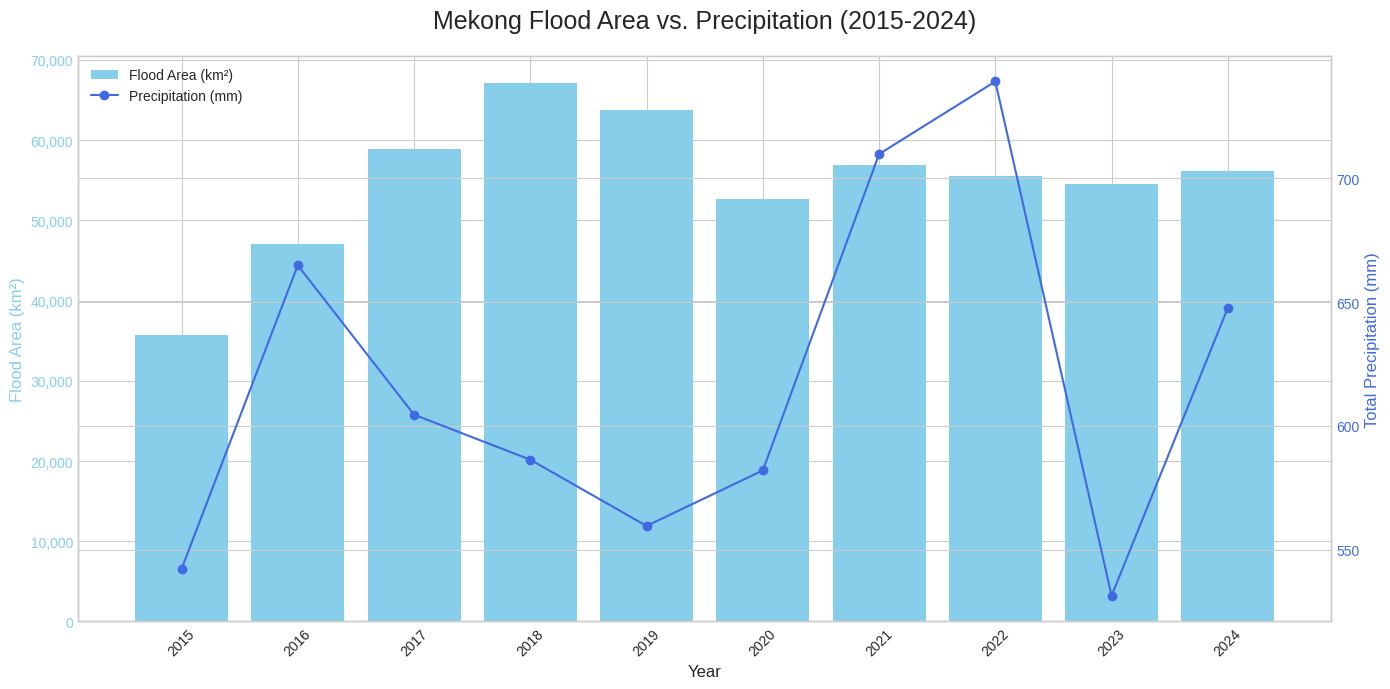

In [26]:
# Matplotlib 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(figsize=(14, 7))

# 왼쪽 Y축: 홍수 면적(막대 그래프)
color_bar = 'skyblue'
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Flood Area (km²)', color=color_bar, fontsize=12)
ax1.bar(df_analysis['year'], df_analysis['area_km2'], color=color_bar, label='Flood Area (km²)')
ax1.tick_params(axis='y', labelcolor=color_bar)
ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))


# 오른쪽 Y축: 강수량(선 그래프)
ax2 = ax1.twinx()  # ax1과 x축을 공유하는 두 번째 y축 생성
color_line = 'royalblue'
ax2.set_ylabel('Total Precipitation (mm)', color=color_line, fontsize=12)
ax2.plot(df_analysis['year'], df_analysis['precipitation_mm'], color=color_line, marker='o', linestyle='-', label='Precipitation (mm)')
ax2.tick_params(axis='y', labelcolor=color_line)

# 그래프 제목 및 레이아웃 설정
plt.title('Mekong Flood Area vs. Precipitation (2015-2024)', fontsize=18, pad=20)
ax1.set_xticks(df_analysis['year']) # x축 눈금을 연도별로 표시
ax1.tick_params(axis='x', rotation=45)
fig.tight_layout() # 그래프 요소들이 겹치지 않게 조정

# 범례 추가
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

In [27]:
# 심층 분석할 연도 설정 (3단계 그래프를 보고 가장 의심스러운 해로 변경 가능)
case_study_year = 2019

# Sentinel-1 SAR 영상 시각화를 위한 파라미터 (dB 단위)
s1_vis_params = {
    'bands': ['VV'],
    'min': -25, # 물은 매우 어둡게 (-25)
    'max': -5   # 육지는 상대적으로 밝게 (-5)
}

In [28]:
# GIF를 만들 기간 설정 (홍수가 시작되고 절정에 이르는 시기)
start_date_gif = f'{case_study_year}-07-01'
end_date_gif = f'{case_study_year}-10-31'

# Sentinel-1 데이터 필터링
s1_collection_gif = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(aoi) \
    .filterDate(start_date_gif, end_date_gif) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .select('VV') \
    .sort('system:time_start') # 시간 순으로 정렬

print(f"{case_study_year}년 우기 타임랩스 GIF 생성을 시작합니다. (시간이 다소 소요될 수 있습니다)")

# GIF 파일 이름 설정
gif_output_path = f'mekong_flood_{case_study_year}.gif'

# geemap을 사용하여 타임랩스 GIF 생성
geemap.download_ee_video(
    s1_collection_gif,
    video_args={
        'dimensions': 720, # GIF의 크기 (픽셀)
        'region': aoi,
        'framesPerSecond': 5, # 초당 프레임 수
        'bands': ['VV'],
        'min': -25,
        'max': -5
    },
    out_gif=gif_output_path
)

print(f"GIF 파일이 성공적으로 '{gif_output_path}' 이름으로 저장되었습니다.")
print("Colab의 왼쪽 파일 탐색기에서 새로고침하여 다운로드할 수 있습니다.")

2019년 우기 타임랩스 GIF 생성을 시작합니다. (시간이 다소 소요될 수 있습니다)
Generating URL...
Total request size (159073200 pixels) must be less than or equal to 26214400 pixels.
GIF 파일이 성공적으로 'mekong_flood_2019.gif' 이름으로 저장되었습니다.
Colab의 왼쪽 파일 탐색기에서 새로고침하여 다운로드할 수 있습니다.


In [30]:
# 비교할 기간 설정
# 'Before': 홍수가 본격화되기 전
before_start = f'{case_study_year}-06-01'
before_end = f'{case_study_year}-06-30'

# 'After' (During): 홍수가 절정에 달했을 때
after_start = f'{case_study_year}-08-15'
after_end = f'{case_study_year}-09-15'

# 각 기간의 S1 이미지 생성 (노이즈 감소를 위해 .median() 사용)
s1_before = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(aoi).filterDate(before_start, before_end).select('VV').median().clip(aoi)
s1_after = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(aoi).filterDate(after_start, after_end).select('VV').median().clip(aoi)

# RGB False-color Composite 생성 (R: 홍수 중, G: 홍수 전, B: 홍수 전)
# 새롭게 침수된 지역이 붉은색으로 강조됨
change_map = ee.Image.cat([s1_after, s1_before, s1_before])

# 지도 생성
m3 = geemap.Map(center=[11.5, 105.5], zoom=8)
m3.addLayer(change_map, {'min': -25, 'max': -5}, f'Flood Change Map ({case_study_year})')

# 범례 추가
legend_dict = {
    'Newly Flooded Areas': 'FF0000', # 빨간색
    'Permanent Water': '000000',     # 검은색
    'Land (No Change)': 'FFFFFF'     # 흰색/회색
}
m3.add_legend(title='Legend', legend_dict=legend_dict)
m3.addLayerControl()
m3

Map(center=[11.5, 105.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…